In [1]:
import torch
import numpy as np

print(f'Cuda available: {torch.cuda.is_available()}')

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running on: {device}, Device count: {torch.cuda.device_count()}')

Cuda available: True
Running on: cuda, Device count: 2


### Init dataset

In [2]:
from nuscenes import NuScenes
from custom_prediction.helper import PredictHelper

In [3]:
# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = 'D:/ThesisProjects/nuScenes_dataset/'

nusc = NuScenes('v1.0-trainval', dataroot=DATAROOT, verbose=False)

In [4]:
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

#train_samples = get_prediction_challenge_split("train", dataroot=DATAROOT)
valid_samples = get_prediction_challenge_split("train_val", dataroot=DATAROOT)

In [5]:
import matplotlib.pyplot as plt

def show_img(img, size=4):
    plt.figure(figsize=(size, size))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

### Dataset loading

In [6]:
import numpy as np

NPY_DATAROOT = './npy_dataset/'

In [7]:
train_images = np.load(f'{NPY_DATAROOT}train/train_img.npy') #[:100]
train_states = np.load(f'{NPY_DATAROOT}train/train_states.npy') #[:100]
train_labels = np.load(f'{NPY_DATAROOT}train/train_labels.npy') #[:100]

In [8]:
len(train_images), len(train_states), len(train_labels)

(32186, 32186, 32186)

In [9]:
valid_images = np.load(f'{NPY_DATAROOT}validation/validation_img.npy') #[:100]
valid_states = np.load(f'{NPY_DATAROOT}validation/validation_states.npy') #[:100]
valid_labels = np.load(f'{NPY_DATAROOT}validation/validation_labels.npy') #[:100]

In [10]:
len(valid_images), len(valid_states), len(valid_labels)

(8560, 8560, 8560)

In [11]:
# Fix error dot : expected both vectors to have same dtype, but found Double and Float
# Because predictions from MTP in type float32

train_labels = train_labels.astype(np.float32)
valid_labels = valid_labels.astype(np.float32)

### Check data

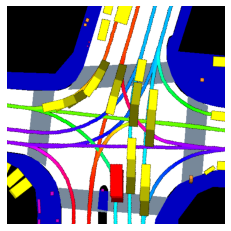

[ 1.02109356 -1.43375038 -0.03491503]

[ 0.04410077  0.4689095   0.09100088  1.0822979   0.08708986  1.6152611
  0.08303186  1.8419956   0.0792407   2.2164626   0.04827162  3.1715548
 -0.02187704  4.358623   -0.24015464  5.944889   -0.7080125   7.526834
 -1.4718102   9.127691   -2.6100404  10.687594   -4.4691     12.285151  ]


In [12]:
index_to_check = 50

img = train_images[index_to_check]
img = img.reshape((500, 500, 3))

show_img(img)

print(train_states[index_to_check])
print()
print(train_labels[index_to_check])

### Clear everything before start

In [13]:
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

In [14]:
# free_gpu_cache()

### Train

In [15]:
import wandb

wandb.init(
    project='MTP_1.0',
    entity='techtoker',
    config={    
        "epoch": 32,
        "batch_size": 32,
        "num_modes": 3,
        "lr":5e-5,
        "notes": "second try"
    })

config = wandb.config

wandb: Currently logged in as: techtoker (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [16]:
from torch.utils.data import DataLoader, Dataset

import numpy as np
from typing import List

class NuscenesDataset(Dataset):
    def __init__(self, features: List[str], states: List[str], labels: List[str]):
        self.features = features
        self.states = states
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index: int):

        image = self.features[index].reshape((500, 500, 3))
        image = torch.Tensor(image).permute(2, 0, 1)
        
        agent_state_vector = torch.Tensor(self.states[index])
        ground_truth = self.labels[index].reshape((12, 2))

        # Convert to [batch_size, 1, 12, 2]
        # Because loss function need that format
        ground_truth = np.expand_dims(ground_truth, 0)

        return image, agent_state_vector, ground_truth

In [17]:
train_ds = NuscenesDataset(train_images, train_states, train_labels)
train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)

validation_ds = NuscenesDataset(valid_images, valid_states, valid_labels)
validation_dl = DataLoader(train_ds, batch_size=config.batch_size * 2)

In [18]:
image, state, ground_truth = next(iter(train_dl))

print(image.size())
print(state.size())
print(ground_truth.size())

torch.Size([32, 3, 500, 500])
torch.Size([32, 3])
torch.Size([32, 1, 12, 2])


In [19]:
# Output has 50 entries.
# The first 24 are x,y coordinates (in the agent frame) over the next 6 seconds at 2 Hz for the first mode.
# The second 24 are the x,y coordinates for the second mode.
# The last 2 are the logits of the mode probabilities
# mtp(image, state)

In [20]:
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP, MTPLoss

backbone = ResNetBackbone('resnet50')
model = MTP(backbone, num_modes=config.num_modes)
model = torch.nn.DataParallel(model)

model = model.to(device)

loss_function = MTPLoss(config.num_modes)

In [21]:
from torch.optim import Adam

# Pass to optimizer only params with requires_grad
params_to_update = []

for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

In [22]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, StepLR, ReduceLROnPlateau

optimizer = Adam(params_to_update, lr=config.lr, weight_decay=5e-4)
#scheduler_exp = ExponentialLR(optimizer, gamma=0.9)
scheduler_exp = StepLR(optimizer, step_size=4, gamma=0.8)

scheduler_onPlateau = ReduceLROnPlateau(optimizer, 'min')

In [23]:
import os

# Create folder for all models
dir = os.path.join('./models')
if not os.path.exists(dir):
    os.mkdir(dir)

In [24]:
import nuscenes.eval.prediction.metrics as metrics
from collections import defaultdict
from typing import List, Dict, Any


def GetPrediction(model, instance_token, sample_token, img, state):

    img = img.unsqueeze(0).to(device)
    state = state.unsqueeze(0).to(device)

    predict = model(img, state)
    predict = predict[0]

    trajectories_set = predict[:len(predict) - config.num_modes]
    trajectories_set = trajectories_set.reshape(config.num_modes, 12, 2)
        
    mode_probabilities = predict[-config.num_modes:]

    sorted_logits_indexes = mode_probabilities.argsort(descending=True)
    sorted_trajectories = trajectories_set[sorted_logits_indexes]
    
    mode_probabilities = mode_probabilities.cpu().detach().numpy()
    sorted_trajectories = sorted_trajectories.cpu().detach().numpy()
    
    top_trajectories = sorted_trajectories[:10]
    top_probabilities = mode_probabilities[:10]
    
    # Prediction contains more than 25 modes. 
    prediction = metrics.Prediction(instance_token, sample_token, top_trajectories, top_probabilities)

    return prediction


def GetMetrics(model, valid_ds, valid_samples):
    
    # Define metrics function and container
    metric_functions = [metrics.MinFDEK([1, 5], aggregators=[metrics.RowMean()]),
                        metrics.MinADEK([5, 10], aggregators=[metrics.RowMean()]),
                        metrics.MissRateTopK([5, 10], tolerance=2, aggregators=[metrics.RowMean()])]

    num_predictions = len(valid_ds) # Amount of prediction rows (equals of len of validation)
    metrics_container = {metric.name: np.zeros((num_predictions, metric.shape)) for metric in metric_functions}
    
    # Prediction loop
    for idx in tqdm(range(len(valid_ds))):
        feature, state, ground_truth = valid_ds[idx]
        instance_tkn, sample_tkn = valid_samples[idx].split("_")
                        
        # Make prediction
        prediction = GetPrediction(model, instance_tkn, sample_tkn, feature, state)
        
        # Get ground_truth
        gt = ground_truth.reshape((12, 2))

        # Calculate metrics
        for metric in metric_functions:
            metrics_container[metric.name][idx] = metric(gt, prediction)
    
    # Metrics aggregations
    aggregations: Dict[str, Dict[str, List[float]]] = defaultdict(dict)

    for metric in metric_functions:
        for agg in metric.aggregators:
            aggregations[metric.name][agg.name] = agg(metrics_container[metric.name])

    return aggregations

In [25]:
from tqdm import tqdm
import time

def loss_batch(model, loss_func, img, state_vec, ground_truth, opt=None):
    img = img.to(device)
    state_vec = state_vec.to(device)
    ground_truth = ground_truth.to(device)
        
    predicted_logits = model(img, state_vec)
    loss = loss_func(predicted_logits, ground_truth)

    # For validation optimizer is None, thus we dont perform backprop
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    # Return losses and amount of items
    #print(f"{loss.item()}; {len(img)}")
    return loss.item(), len(img)


def train_step(model, train_dl, loss_func, opt):
    model.train()

    losses = []
    nums = []
    for img, state_vec, gt in tqdm(train_dl):
        loss, num = loss_batch(model, loss_func, img, state_vec, gt, opt)
        losses.append(loss)
        nums.append(num)
        
    # Calculate train loss
    train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    return train_loss


def validation_step(model, valid_dl, loss_func):
    tqdm.write("Validation step")
    time.sleep(0.5)
    
    model.eval()

    with torch.no_grad():
        losses = []
        nums = []
        for img, state_vec, gt in tqdm(valid_dl):
            loss, num = loss_batch(model, loss_func, img, state_vec, gt)
            losses.append(loss)
            nums.append(num)
        
        # Calculate validation loss
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        scheduler_exp.step()
        scheduler_onPlateau.step(val_loss)
        
    return val_loss


def log_metrics(model, valid_ds, valid_samples, start_epoch_time, best_loss, train_loss, val_loss):
    
    # Calculate metrics on validation set
    tqdm.write("Calculate metrics:")
    time.sleep(0.5)
    
    metricsRes = GetMetrics(model, valid_ds, valid_samples)
    
    minFDE_1 = metricsRes['MinFDEK']['RowMean'][0]
    minFDE_5 = metricsRes['MinFDEK']['RowMean'][1]
    minADEK_5 = metricsRes['MinADEK']['RowMean'][0]
    minADEK_10 = metricsRes['MinADEK']['RowMean'][1]
    missRateTopK2_5 = metricsRes['MissRateTopK_2']['RowMean'][0]
    missRateTopK2_10 = metricsRes['MissRateTopK_2']['RowMean'][1]    

    wandb.log({'Train loss': train_loss,
               'Val loss': val_loss,
               'Learning_rate': scheduler_exp.get_last_lr()[0],
               'minFDE_1': minFDE_1,
               'minFDE_5': minFDE_5,
               'minADEK_5': minADEK_5,
               'minADEK_10': minADEK_10,
               'missRateTopK2_5':missRateTopK2_5,
               'missRateTopK2_10':missRateTopK2_10
              })
        
    print(f"Epoch {current_epoch + 1}; Train loss: {train_loss:0.2f}; Val loss: {val_loss:0.2f}; Best VL: {best_loss:0.2f}; Time: {(time.time() - start_epoch_time):0.2f} sec;")

In [26]:
import copy

current_epoch = 0
best_model_wts = copy.deepcopy(model.state_dict())

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, valid_ds, valid_samples):
    global current_epoch
    global best_model_wts
    
    best_loss = 999.0

    for epoch in range(epochs):
        start_epoch_time = time.time()
        tqdm.write('-' * 30)
        tqdm.write(f'Epoch: {epoch + 1}/{epochs}')
        time.sleep(0.5)
        
        train_loss = train_step(model, train_dl, loss_func, opt)        
        val_loss = validation_step(model, valid_dl, loss_func)  
        
        # deep copy the model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        log_metrics(model, valid_ds, valid_samples, start_epoch_time, best_loss, train_loss, val_loss)
            
        torch.save(copy.deepcopy(model.state_dict()), f'./Models/MTP_m3_e{current_epoch}_{best_loss:0.2f}.pth')
        current_epoch += 1

In [27]:
fit(config.epoch, model, loss_function, optimizer, train_dl, validation_dl, validation_ds, valid_samples)

------------------------------
Epoch: 1/32


  0%|                                                                                         | 0/1006 [00:00<?, ?it/s]C:\Program Files\anaconda3\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:34<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [03:59<00:00,  2.10it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:41<00:00, 53.11it/s]


Epoch 1; Train loss: 4.23; Val loss: 3.57; Best VL: 3.57; Time: 976.24 sec;
------------------------------
Epoch: 2/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:35<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [03:54<00:00,  2.14it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:41<00:00, 53.07it/s]


Epoch 2; Train loss: 3.20; Val loss: 3.00; Best VL: 3.00; Time: 973.21 sec;
------------------------------
Epoch: 3/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:27<00:00,  1.77it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [03:57<00:00,  2.12it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:38<00:00, 54.18it/s]


Epoch 3; Train loss: 2.80; Val loss: 2.89; Best VL: 2.89; Time: 963.89 sec;
------------------------------
Epoch: 4/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:34<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:01<00:00,  2.08it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:37<00:00, 54.40it/s]


Epoch 4; Train loss: 2.65; Val loss: 2.55; Best VL: 2.55; Time: 974.93 sec;
------------------------------
Epoch: 5/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:34<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [03:59<00:00,  2.10it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:40<00:00, 53.24it/s]


Epoch 5; Train loss: 2.53; Val loss: 2.59; Best VL: 2.55; Time: 976.16 sec;
------------------------------
Epoch: 6/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:36<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:00<00:00,  2.09it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:38<00:00, 53.91it/s]


Epoch 6; Train loss: 2.44; Val loss: 2.30; Best VL: 2.30; Time: 977.69 sec;
------------------------------
Epoch: 7/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:37<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:01<00:00,  2.08it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:41<00:00, 53.08it/s]


Epoch 7; Train loss: 2.33; Val loss: 2.26; Best VL: 2.26; Time: 981.90 sec;
------------------------------
Epoch: 8/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:34<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:03<00:00,  2.06it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:44<00:00, 52.03it/s]


Epoch 8; Train loss: 2.26; Val loss: 2.16; Best VL: 2.16; Time: 984.85 sec;
------------------------------
Epoch: 9/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:35<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:02<00:00,  2.07it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:42<00:00, 52.71it/s]


Epoch 9; Train loss: 2.15; Val loss: 2.11; Best VL: 2.11; Time: 982.57 sec;
------------------------------
Epoch: 10/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:39<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:04<00:00,  2.06it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:42<00:00, 52.54it/s]


Epoch 10; Train loss: 2.09; Val loss: 2.01; Best VL: 2.01; Time: 988.39 sec;
------------------------------
Epoch: 11/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:36<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:01<00:00,  2.09it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:44<00:00, 52.19it/s]


Epoch 11; Train loss: 2.04; Val loss: 2.08; Best VL: 2.01; Time: 982.76 sec;
------------------------------
Epoch: 12/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:36<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [03:58<00:00,  2.11it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:38<00:00, 54.12it/s]


Epoch 12; Train loss: 1.99; Val loss: 2.13; Best VL: 2.01; Time: 975.15 sec;
------------------------------
Epoch: 13/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:36<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:00<00:00,  2.09it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:39<00:00, 53.71it/s]


Epoch 13; Train loss: 1.90; Val loss: 1.87; Best VL: 1.87; Time: 977.97 sec;
------------------------------
Epoch: 14/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:37<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:02<00:00,  2.07it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:36<00:00, 54.67it/s]


Epoch 14; Train loss: 1.86; Val loss: 1.79; Best VL: 1.79; Time: 978.04 sec;
------------------------------
Epoch: 15/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:36<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:06<00:00,  2.04it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:43<00:00, 52.21it/s]


Epoch 15; Train loss: 1.81; Val loss: 1.77; Best VL: 1.77; Time: 987.96 sec;
------------------------------
Epoch: 16/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:41<00:00,  1.73it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:04<00:00,  2.05it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:43<00:00, 52.38it/s]


Epoch 16; Train loss: 1.78; Val loss: 1.84; Best VL: 1.77; Time: 991.00 sec;
------------------------------
Epoch: 17/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:35<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:02<00:00,  2.07it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:42<00:00, 52.76it/s]


Epoch 17; Train loss: 1.72; Val loss: 1.64; Best VL: 1.64; Time: 982.15 sec;
------------------------------
Epoch: 18/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:38<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:03<00:00,  2.06it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:42<00:00, 52.65it/s]


Epoch 18; Train loss: 1.69; Val loss: 1.68; Best VL: 1.64; Time: 986.11 sec;
------------------------------
Epoch: 19/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:37<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:04<00:00,  2.05it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:43<00:00, 52.41it/s]


Epoch 19; Train loss: 1.67; Val loss: 1.61; Best VL: 1.61; Time: 986.90 sec;
------------------------------
Epoch: 20/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:36<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:02<00:00,  2.07it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:40<00:00, 53.21it/s]


Epoch 20; Train loss: 1.66; Val loss: 1.63; Best VL: 1.61; Time: 981.71 sec;
------------------------------
Epoch: 21/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:36<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:04<00:00,  2.06it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:38<00:00, 54.14it/s]


Epoch 21; Train loss: 1.60; Val loss: 1.55; Best VL: 1.55; Time: 979.99 sec;
------------------------------
Epoch: 22/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:34<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:04<00:00,  2.06it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:41<00:00, 52.86it/s]


Epoch 22; Train loss: 1.58; Val loss: 1.56; Best VL: 1.55; Time: 982.40 sec;
------------------------------
Epoch: 23/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:34<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:05<00:00,  2.05it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:44<00:00, 52.18it/s]


Epoch 23; Train loss: 1.56; Val loss: 1.54; Best VL: 1.54; Time: 985.45 sec;
------------------------------
Epoch: 24/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:39<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:05<00:00,  2.05it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:42<00:00, 52.54it/s]


Epoch 24; Train loss: 1.55; Val loss: 1.47; Best VL: 1.47; Time: 989.24 sec;
------------------------------
Epoch: 25/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:34<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:05<00:00,  2.05it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:41<00:00, 53.07it/s]


Epoch 25; Train loss: 1.51; Val loss: 1.49; Best VL: 1.47; Time: 983.33 sec;
------------------------------
Epoch: 26/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:37<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:05<00:00,  2.05it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:42<00:00, 52.65it/s]


Epoch 26; Train loss: 1.49; Val loss: 1.46; Best VL: 1.46; Time: 986.77 sec;
------------------------------
Epoch: 27/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:40<00:00,  1.73it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:06<00:00,  2.04it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:42<00:00, 52.77it/s]


Epoch 27; Train loss: 1.47; Val loss: 1.51; Best VL: 1.46; Time: 990.26 sec;
------------------------------
Epoch: 28/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:37<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:08<00:00,  2.02it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:39<00:00, 53.69it/s]


Epoch 28; Train loss: 1.46; Val loss: 1.44; Best VL: 1.44; Time: 986.77 sec;
------------------------------
Epoch: 29/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:36<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:04<00:00,  2.06it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:41<00:00, 52.91it/s]


Epoch 29; Train loss: 1.43; Val loss: 1.39; Best VL: 1.39; Time: 984.46 sec;
------------------------------
Epoch: 30/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:37<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:05<00:00,  2.05it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:42<00:00, 52.73it/s]


Epoch 30; Train loss: 1.41; Val loss: 1.36; Best VL: 1.36; Time: 986.78 sec;
------------------------------
Epoch: 31/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:35<00:00,  1.75it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:05<00:00,  2.05it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:42<00:00, 52.66it/s]


Epoch 31; Train loss: 1.40; Val loss: 1.36; Best VL: 1.36; Time: 985.61 sec;
------------------------------
Epoch: 32/32


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [09:38<00:00,  1.74it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [04:06<00:00,  2.04it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [02:41<00:00, 53.04it/s]


Epoch 32; Train loss: 1.39; Val loss: 1.39; Best VL: 1.36; Time: 987.82 sec;
